# **Sentiment Analysis and Classification of ruangguru's Clash of Champions YouTube Comments**

This project performs sentiment analysis and builds a text classification model to categorize YouTube comments from ruangguru's Clash of Champions. We use sentiment analysis to initially label our unlabeled dataset, classifying comments as negative, neutral, or positive. The goal is to create a model that can accurately label new comments, potentially expanding beyond sentiment to categorize them based on topic, relevance, or engagement. This model could benefit ruangguru by automating comment analysis and improving community engagement.

**Key points:**

* **Dataset:**
  - YouTube comments extracted from ruangguru's Clash of Champions episodes 1-3.
  - Date of Collection: Tueday July 29, 2024 (9:26 AM)
  - Tool: youtube_comment_downloader from [egbertbouman's GitHub](https://github.com/egbertbouman)
* **Labeling:** Initial labeling using sentiment analysis.
* **Model:** Text classification model trained on sentiment-labeled comments.
* **Potential:** Expand model beyond sentiment, benefit ruangguru through automated comment analysis.

**Credit:**

1. [ruangguru's YouTube](https://www.youtube.com/@Ruangguru)
2. normalized_term from [teguhary's GitHub](https://github.com/teguhary)
3. MPStemmer() from [ariaghora's GitHub](https://github.com/ariaghora)
4. Lexicon for sentiment analysis from [angelmetanosaa's GitHub](https://github.com/angelmetanosaa)

**Q&A:**

1.
- **Q:** Why not create different models for each episode?
- **A:** Creating separate models for each episode would result in insufficient training data for each individual model, leading to poorer performance. Combining the data allows for a more robust model.
2.
- **Q:** Why use `normalized_term` from [teguhary's GitHub](https://github.com/teguhary)?
- **A:** Teguhary's `normalized_term` function is chosen for its comprehensive normalization capabilities, exceeding other available options in my experience.
3.
- **Q:** Why use `MPStemmer()` instead of Sastrawi?
- **A:** Please refer to [ariaghora's GitHub](https://github.com/ariaghora) for a detailed comparison of `MPStemmer()` and Sastrawi, outlining the reasons for choosing `MPStemmer()` in this project.
4.
- **Q:** Why use the Lexicon for sentiment analysis from [angelmetanosaa's GitHub](https://github.com/angelmetanosaa)?
- **A:** While not finding a superior alternative, this lexicon, taught by Dicoding Academy, was a readily available and suitable option for the sentiment analysis task.
5.
- **Q:** Could any potential problems arise from using [angelmetanosaa's GitHub](https://github.com/angelmetanosaa) lexicon for inference?
- **A:** Yes, there could be problems. The lexicon used in the model has an imbalanced distribution, with 3609 positive terms and 6607 negative terms. This imbalance could lead to an overestimation of negative sentiment when analyzing comments. However, if you don't have alternative options readily available, using this lexicon might still provide some valuable insights despite its limitations.
6.
- **Q:** Are there any potential issues to be aware of with this project?
- **A:** Yes, as this project involves text classification in bahasa Indonesia, there are limitations in the resources available. Specifically, the tools for normalization, stemming, and lexicon building are not as robust as those available for English. This could impact the accuracy and effectiveness of the analysis.

**[Project's Repository Link](https://github.com/kevinadityaikhsan/ruangguru-sentiment-analysis-classification)**

## **1. Import Library**

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import csv
import requests
import unicodedata
import json
import os
import joblib

from io import StringIO, BytesIO

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (
    Embedding,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    Conv1D,
    MaxPooling1D,
    SpatialDropout1D
)
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git

  Cloning https://github.com/ariaghora/mpstemmer.git to /tmp/pip-req-build-jgfeylcv
  Running command git clone --filter=blob:none --quiet https://github.com/ariaghora/mpstemmer.git /tmp/pip-req-build-jgfeylcv
  Resolved https://github.com/ariaghora/mpstemmer.git to commit 25a5fd923af163a7eac3a5ec976984156ca8fa8b
  Preparing metadata (setup.py) ... done
  Created wheel for mpstemmer: filename=mpstemmer-0.1.0-py3-none-any.whl size=99802 sha256=be387163b0760061c71df3f0a6ebcfe855ac9edd9f3d7ebf9bb68d4adb64de11
  Stored in directory: /tmp/pip-ephem-wheel-cache-p4ga2vva/wheels/e0/b7/dd/9a80a3b7a05fe9e3252476ddf25da4faabddcec1b9e88fc32c
Successfully built mpstemmer


In [3]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.8 MB/s eta 0:00:00


In [4]:
from mpstemmer import MPStemmer

stemmer = MPStemmer()

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
stopwords = set(stopwords.words('indonesian'))

In [7]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 10.3 MB/s eta 0:00:00


In [8]:
import emoji

## **2. Load Dataset**

In [9]:
url = r'https://github.com/kevinadityaikhsan/ruangguru-sentiment-analysis-classification/raw/main/ruangguru_eps1-3.csv'
corpus = pd.read_csv(url)
corpus

,comment
0,"Yuk, konsultasi dan klaim diskonnya sekarang di https://bit.ly/KlaimDiskonCOC"
1,Serem njirr kalo liat orang pinter kompetisi
2,Kami sih sama ada kayak caslh of campion
3,Waahh merinding gw
4,Siapa dari sd imam asy fi\n\n👇
...,...
42808,Samaa😂
42809,ternyata belum ya
42810,"lah pantes tadi sore udah nonton , terus ilang ​ @zhang.xke7"
42811,UDAAAA WEEE


## **3. Dataset Preprocessing**

In [10]:
# Check duplicate
corpus.duplicated().sum()

2352

In [11]:
# Remove duplicate
corpus.drop_duplicates(inplace=True)
corpus.reset_index(drop=True, inplace=True)
corpus.shape

(40461, 1)

In [12]:
# Load normalized terms
normalized_term = {}

url = 'https://github.com/teguhary/Automated-labelling-Inset-Lexicon/raw/master/Data/kamus_kata_alay.xlsx'
response = requests.get(url)

if response.status_code == 200:
    df = pd.read_excel(BytesIO(response.content))
    normalized_term = dict(zip(df[df.columns[0]], df[df.columns[1]]))

else:
    print('Failed to fetch normalized words data')

In [13]:
# Function for corpus cleaning
def clean_corpus_docs(doc):
    # Remove emojis
    doc = emoji.replace_emoji(doc, replace='')

    # Normalize Unicode characters (e.g., combining characters)
    doc = unicodedata.normalize('NFKD', doc)

    # Lowercase the doc
    doc = doc.lower()

    # Remove mentions, hashtags, RTs, URLs, numbers, and punctuation
    doc = re.sub(r'(@[A-Za-z0-9]+|#[A-Za-z0-9]+|RT[\s]|http\S+|\d+|[^\w\s])', '', doc)

    # Remove extra whitespace and leading/trailing spaces
    doc = re.sub(r'\s+', ' ', doc).strip()

    # Reduce repeated characters (e.g., "sukaaa" to "suka", but keep "tuannya" as "tuannya", not "tuanya")
    doc = re.sub(r'(.)\1{2,}', r'\1', doc)

    # Tokenize the doc
    tokens = word_tokenize(doc)

    # Normalize and stem tokens
    tokens = [normalized_term.get(token, token) for token in tokens]  # Normalize
    tokens = [stemmer.stem(token) for token in tokens]              # Stem

    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]

    # Remove token with characters <= 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens  # Return list of processed terms

In [14]:
# Clean the corpus
corpus['tokens'] = corpus['comment'].apply(clean_corpus_docs)

In [15]:
# Drop duplicate
corpus.drop_duplicates(subset='tokens', inplace=True)
corpus.reset_index(drop=True, inplace=True)
corpus.shape

(32809, 2)

In [16]:
# Remove row with empty token
corpus = corpus[corpus['tokens'].apply(lambda x: len(x)) > 0]
corpus.reset_index(drop=True, inplace=True)
corpus.shape

(32808, 2)

In [17]:
# Cleaned and tokenized corpus
corpus

,comment,tokens
0,"Yuk, konsultasi dan klaim diskonnya sekarang di https://bit.ly/KlaimDiskonCOC","[ayo, konsultasi, klaim, diskon]"
1,Serem njirr kalo liat orang pinter kompetisi,"[seram, anjir, lihat, orang, pintar, kompetisi]"
2,Kami sih sama ada kayak caslh of campion,"[sih, kayak, caslh, campion]"
3,Waahh merinding gw,"[waahh, merinding, gue]"
4,Siapa dari sd imam asy fi\n\n👇,"[imam, asy]"
...,...,...
32803,"udah diupload kak, cuma disetting premiere tayangnya sesuai jadwal 😅😂","[upload, kak, tting, premiere, tayang, sesuai, jadwal]"
32804,samaa weehh,[weehh]
32805,ternyata belum ya,"[nyata, iya]"
32806,"lah pantes tadi sore udah nonton , terus ilang ​ @zhang.xke7","[sore, tonton, hilang, xke]"


## **4. Dataset Labeling**

In [18]:
# Read positive term dictionary data from GitHub
lexicon_positive = dict()

# Send an HTTP request to get a CSV file from GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    # If the request succeeds
    # Read response text as a CSV file using a CSV reader with comma separators
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        # Loop through each row in a CSV file
        # Added positive term and their scores to the lexicon_positive dictionary
        lexicon_positive[row[0]] = int(row[1])

else:
    print('Failed to fetch positive lexicon date')

# Read negative term dictionary data from GitHub
lexicon_negative = dict()

# Send an HTTP request to get a CSV file from GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    # If the request succeeds
    # Read response text as a CSV file using a CSV reader with comma separators
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        # Loop through each row in a CSV file
        # Added negative term and their scores to the lexicon_negative dictionary
        lexicon_negative[row[0]] = int(row[1])

else:
    print('Failed to fetch negative lexicon date')

In [19]:
# Show number of lexicon for each categories
print(len(lexicon_positive))
print(len(lexicon_negative))

3609
6607


In [20]:
# Function to determine the sentiment polarity of comments
def sentiment_analysis_lexicon_indonesia(doc):
    # For term in doc:
    score = 0 # Initialize sentiment score to 0
    for term in doc:
        # Loops every term in the doc
        if (term in lexicon_positive):
            # If the term is in the positive dictionary, add its score to the sentiment score
            score = score + lexicon_positive[term]

    for term in doc:
        # Loops every term in the doc again
        if (term in lexicon_negative):
            # If the term is in the negative dictionary, subtract its score to the sentiment score
            score = score + lexicon_negative[term]

    # Initialize polarity variables
    polarity = ''

    if score > 0:
        # If the sentiment score is greater than or equal to 0, then the polarity is positive
        polarity = 'positive'
    elif score < 0:
        # If the sentiment score is less than 0, then the polarity is negative
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [21]:
# Show the total number for each polarity
results = corpus['tokens'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
corpus['polarity_score'] = results[0]
corpus['polarity'] = results[1]
print(corpus['polarity'].value_counts())

polarity
negative    14503
positive    10523
neutral      7782
Name: count, dtype: int64


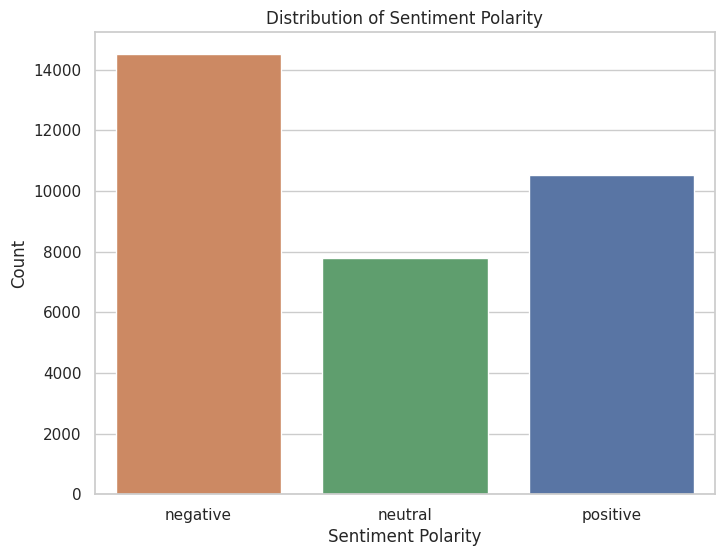

In [22]:
# Visualize sentiment polarity distribution
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.countplot(x='polarity', data=corpus, order=['negative', 'neutral', 'positive'], hue='polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Polarity')
plt.show()

In [23]:
# Encode polarity to numerical label
le = LabelEncoder()
corpus['label'] = le.fit_transform(corpus['polarity'])
corpus

,comment,tokens,polarity_score,polarity,label
0,"Yuk, konsultasi dan klaim diskonnya sekarang di https://bit.ly/KlaimDiskonCOC","[ayo, konsultasi, klaim, diskon]",9,positive,2
1,Serem njirr kalo liat orang pinter kompetisi,"[seram, anjir, lihat, orang, pintar, kompetisi]",-3,negative,0
2,Kami sih sama ada kayak caslh of campion,"[sih, kayak, caslh, campion]",-3,negative,0
3,Waahh merinding gw,"[waahh, merinding, gue]",-3,negative,0
4,Siapa dari sd imam asy fi\n\n👇,"[imam, asy]",-2,negative,0
...,...,...,...,...,...
32803,"udah diupload kak, cuma disetting premiere tayangnya sesuai jadwal 😅😂","[upload, kak, tting, premiere, tayang, sesuai, jadwal]",6,positive,2
32804,samaa weehh,[weehh],0,neutral,1
32805,ternyata belum ya,"[nyata, iya]",2,positive,2
32806,"lah pantes tadi sore udah nonton , terus ilang ​ @zhang.xke7","[sore, tonton, hilang, xke]",-5,negative,0


### **4.1. Word Cloud**

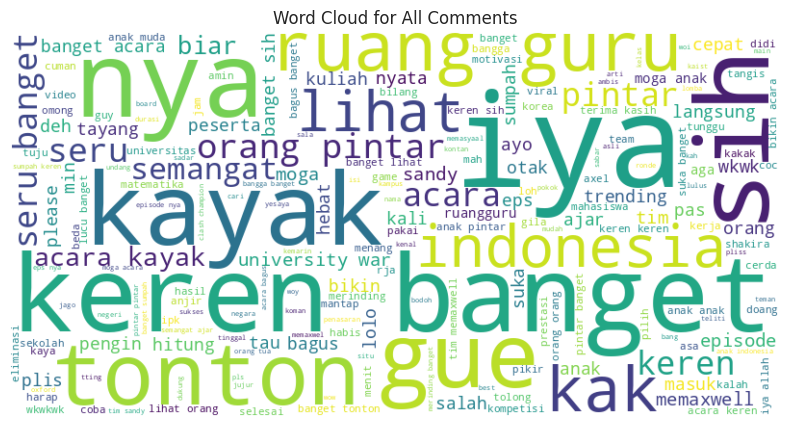

In [24]:
# Join all tokens into a single string
all_tokens = ' '.join([' '.join(tokens) for tokens in corpus['tokens']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tokens)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Comments')
plt.show()

### **4.2. Negative Word Cloud**

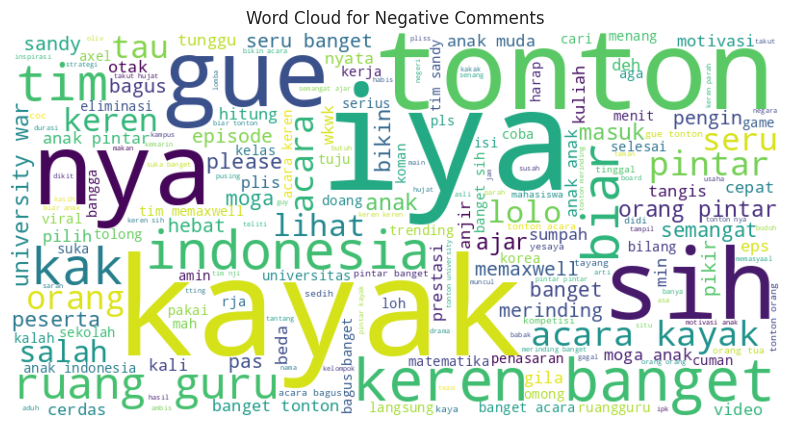

In [25]:
# Filter for negative comments
negative_comments = corpus[corpus['polarity'] == 'negative']

# Join tokens from negative comments into a single string
negative_tokens = ' '.join([' '.join(tokens) for tokens in negative_comments['tokens']])

# Create a WordCloud object
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_tokens)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Comments')
plt.show()

### **4.3. Neutral Word Cloud**

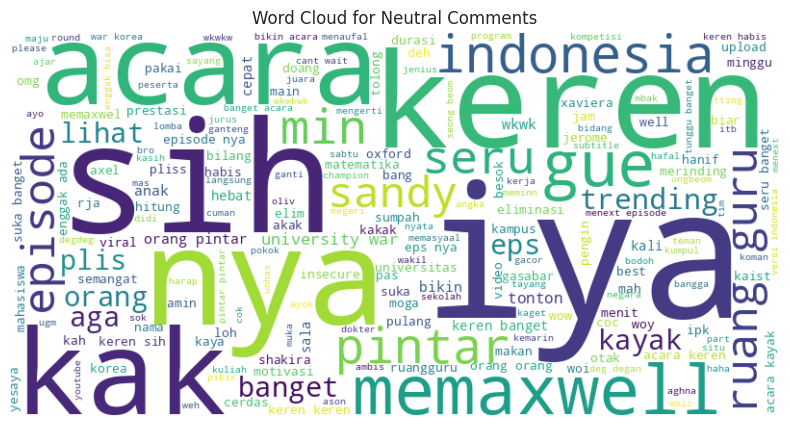

In [26]:
# Filter for neutral comments
neutral_comments = corpus[corpus['polarity'] == 'neutral']

# Join tokens from neutral comments into a single string
neutral_tokens = ' '.join([' '.join(tokens) for tokens in neutral_comments['tokens']])

# Create a WordCloud object
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_tokens)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Comments')
plt.show()

### **4.4. Positive Word Cloud**

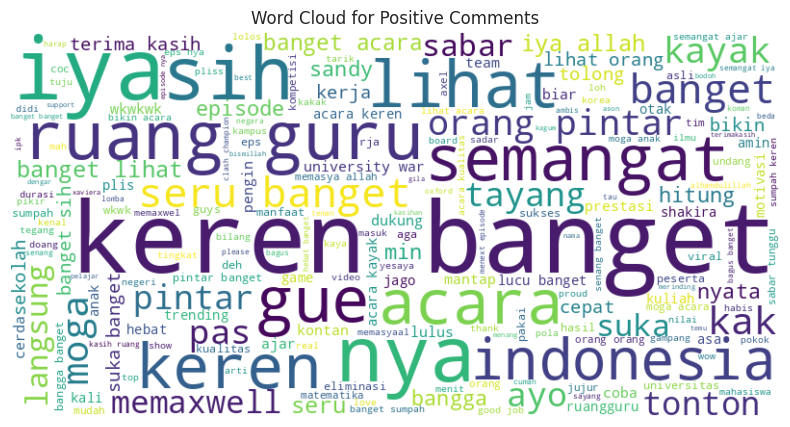

In [27]:
# Filter for positive comments
positive_comments = corpus[corpus['polarity'] == 'positive']

# Join tokens from positive comments into a single string
positive_tokens = ' '.join([' '.join(tokens) for tokens in positive_comments['tokens']])

# Create a WordCloud object
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_tokens)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Comments')
plt.show()

## **5. Modeling**

### **5.1. TF-IDF with Multi-Layer Perceptron**

In [28]:
# Prepare data
# Extract tokenized text ('tokens') from the 'corpus' as our features (X)
X1 = corpus['tokens']

# Extract corresponding labels ('label') from the 'corpus' as our target variable (y)
y1 = corpus['label']

# TF-IDF Vectorization (Term Frequency-Inverse Document Frequency)
# Initialize the TF-IDF vectorizer object
tfidf = TfidfVectorizer()

# Transform the tokenized text (X) into a TF-IDF matrix (X_tfidf):
# 1. Join each list of tokens into a single string (' '.join(tokens))
# 2. Fit the vectorizer to the corpus (learn vocabulary and IDF weights)
# 3. Transform the corpus into a numerical TF-IDF representation
X1_tfidf = tfidf.fit_transform([' '.join(tokens) for tokens in X1])

# Split data into training and testing sets
# 'stratify' ensures the class distribution is similar in both sets (important for imbalanced datasets)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_tfidf, y1, test_size=0.2, random_state=42, stratify=y1)

In [29]:
# Save tfidf
os.makedirs('saved_models', exist_ok=True)
joblib.dump(tfidf, 'saved_models/tfidf.pkl')

['saved_models/tfidf.pkl']

In [30]:
# Neural Network Model
# Initialize a Multi-Layer Perceptron (MLP) classifier for text classification:
model = MLPClassifier(
    hidden_layer_sizes=(100,),  # One hidden layer with 100 neurons
    activation='relu',          # Rectified Linear Unit (ReLU) activation function
    solver='adam',              # Adam optimization algorithm
    random_state=42             # Set a random seed for reproducibility
)

# Train (fit) the model on the training data (X_train, y_train)
model.fit(X1_train, y1_train)

# Make predictions on the test data (X_test)
y1_pred = model.predict(X1_test)

In [31]:
# Evaluate the model's performance
test_accuracy = accuracy_score(y1_test, y1_pred).round(3)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.927


In [32]:
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2901
           1       0.85      0.92      0.88      1556
           2       0.94      0.93      0.93      2105

    accuracy                           0.93      6562
   macro avg       0.92      0.93      0.92      6562
weighted avg       0.93      0.93      0.93      6562



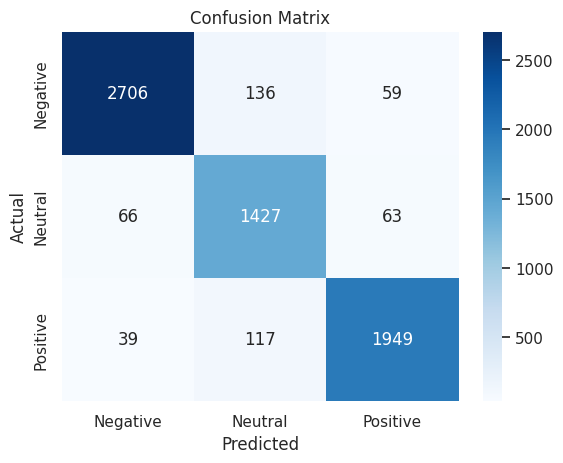

In [33]:
# Visualize Confusion Matrix
cm = confusion_matrix(y1_test, y1_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Save TF-IDF Vectorization Based Model for 3-Class Text Classification with Multi-Layer Perceptron to TFIDF_3C_MLP.pkl

In [34]:
# Save model
os.makedirs('saved_models', exist_ok=True)
joblib.dump(model, 'saved_models/TFIDF_3C_MLP.pkl')

['saved_models/TFIDF_3C_MLP.pkl']

### **5.2. TF-IDF with Dense Layer**

In [35]:
# Callbacks
# ModelCheckpoint Callback
checkpoint_filepath = os.path.join('saved_models', 'TFIDF_3C_DL.keras')
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,      # Path to save the best model
    monitor='val_accuracy',            # Metric to monitor (validation accuracy)
    save_best_only=True,               # Only save the model with the best value
    mode='max',                        # Monitor for the maximum value (for accuracy)
    save_weights_only=False,           # Save the entire model (not just weights)
    verbose=1                          # Print messages when a new best is found
)

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Metric to monitor (validation accuracy)
    patience=10,                       # Number of epochs with no improvement to tolerate
    restore_best_weights=True,         # Restore model weights from the epoch with the best value
    verbose=1                          # Print messages when early stopping is triggered
)

In [36]:
# Model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X1_tfidf.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Model
TFIDF_3C_DL = model.fit(
    X1_train, y1_train,
    epochs=100,
    validation_data=(X1_test, y1_test),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6864 - loss: 0.8789
Epoch 1: val_accuracy improved from -inf to 0.87931, saving model to saved_models/TFIDF_3C_DL.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 79s 93ms/step - accuracy: 0.6865 - loss: 0.8787 - val_accuracy: 0.8793 - val_loss: 0.6093
Epoch 2/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9029 - loss: 0.5541
Epoch 2: val_accuracy improved from 0.87931 to 0.89607, saving model to saved_models/TFIDF_3C_DL.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 72s 81ms/step - accuracy: 0.9029 - loss: 0.5541 - val_accuracy: 0.8961 - val_loss: 0.5864
Epoch 3/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9140 - loss: 0.5238
Epoch 3: val_accuracy improved from 0.89607 to 0.90384, saving model to saved_models/TFIDF_3C_DL.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.9140 - loss: 0.5239 - val_accuracy: 0.9038 - val_loss: 0.5505
Epoch 4/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9260 

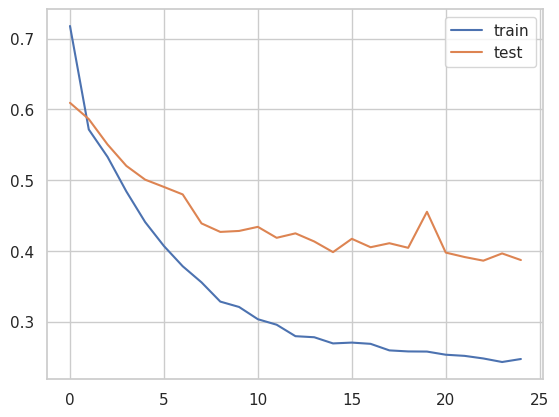

In [37]:
# Visualize train and test loss
plt.plot(TFIDF_3C_DL.history['loss'], label='train')
plt.plot(TFIDF_3C_DL.history['val_loss'], label='test')
plt.legend()
plt.show()

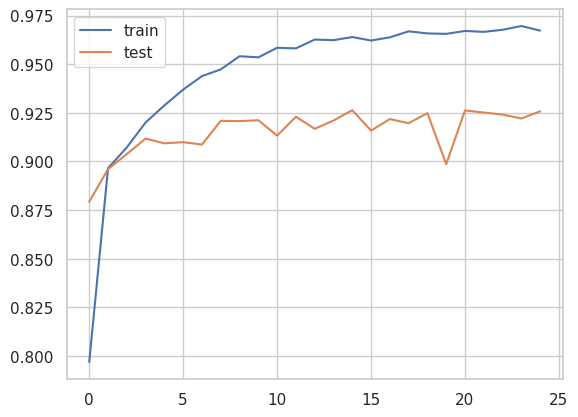

In [38]:
# Visualize train and test accuracy
plt.plot(TFIDF_3C_DL.history['accuracy'], label='train')
plt.plot(TFIDF_3C_DL.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Save TF-IDF Vectorization Based Model for 3-Class Text Classification with Dense Layer to TFIDF_3C_DL.keras

### **5.3. Word Embedding with Global Average Pooling Layer**

In [39]:
# Prepare data
# Extract tokenized text ('tokens') from the 'corpus' as our features (X)
# `.values` converts pandas Series to numpy arrays (required for neural network libraries)
X2 = corpus['tokens'].values

# Extract corresponding labels ('label') from the 'corpus' as our target variable (y)
# `.values` converts pandas Series to numpy arrays
y2 = corpus['label'].values

# Tokenization & Sequencing for Neural Network Input
# Initialize a tokenizer that will keep the 5000 most frequent words in the corpus
tokenizer = Tokenizer(num_words=5000)

# Build the vocabulary (word-to-index mapping) based on the text corpus (X)
tokenizer.fit_on_texts(X2)

# Convert text sequences into integer sequences (word indices)
X2_seq = tokenizer.texts_to_sequences(X2)

# Pad or truncate sequences to a fixed length (128 tokens in this case)
# This ensures consistent input shape for the neural network
X2_padded = pad_sequences(X2_seq, maxlen=128)

# Split data into training and validation sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_padded, y2, test_size=0.2, random_state=42, stratify=y2)

In [40]:
# Save tokenizer
os.makedirs('saved_models', exist_ok=True)
joblib.dump(tokenizer, 'saved_models/tokenizer.pkl')

['saved_models/tokenizer.pkl']

In [41]:
# Callbacks
# ModelCheckpoint Callback
checkpoint_filepath = os.path.join('saved_models', 'WE_3C_GAPL.keras')
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,      # Path to save the best model
    monitor='val_accuracy',            # Metric to monitor (validation accuracy)
    save_best_only=True,               # Only save the model with the best value
    mode='max',                        # Monitor for the maximum value (for accuracy)
    save_weights_only=False,           # Save the entire model (not just weights)
    verbose=1                          # Print messages when a new best is found
)

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Metric to monitor (validation accuracy)
    patience=10,                       # Number of epochs with no improvement to tolerate
    restore_best_weights=True,         # Restore model weights from the epoch with the best value
    verbose=1                          # Print messages when early stopping is triggered
)

In [42]:
# Define Model Parameters
max_features = len(tokenizer.word_index) + 1    # Vocabulary size + 1 (for padding token)
embedding_dim = 128                             # Dimensionality of the word embeddings

# Model Building
model = Sequential([
    # Embedding Layer: Turns word indices into dense vectors of fixed size (embedding_dim)
    Embedding(max_features, embedding_dim, input_length=X2_padded.shape[1]),

    # Spatial Dropout: Often better than regular Dropout for text
    SpatialDropout1D(0.2),

    # Global Average Pooling: Averages over the sequence dimension to reduce dimensionality
    GlobalAveragePooling1D(),

    # Another Dropout Layer: Further regularization to prevent overfitting
    Dropout(0.2),

    # Dense (Output) Layer
    Dense(3, activation='softmax')
])

# Compile the Model
model.compile(
    loss='sparse_categorical_crossentropy',     # Loss for multi-class classification
    optimizer='adam',                           # Optimizer
    metrics=['accuracy']                        # Track accuracy during training
)

# Train the Model (with Callbacks)
WE_3C_GAPL = model.fit(
    X2_train, y2_train,
    epochs=100,                                 # Maximum number of epochs to train
    validation_data=(X2_test, y2_test),             # Data to evaluate after each epoch
    callbacks=[checkpoint, early_stopping]      # Callbacks to monitor progress and save best models
)

Epoch 1/100
820/821 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4449 - loss: 1.0688
Epoch 1: val_accuracy improved from -inf to 0.44209, saving model to saved_models/WE_3C_GAPL.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.4449 - loss: 1.0687 - val_accuracy: 0.4421 - val_loss: 1.0428
Epoch 2/100
820/821 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4711 - loss: 1.0231
Epoch 2: val_accuracy improved from 0.44209 to 0.51326, saving model to saved_models/WE_3C_GAPL.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.4712 - loss: 1.0231 - val_accuracy: 0.5133 - val_loss: 0.9414
Epoch 3/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5843 - loss: 0.9213
Epoch 3: val_accuracy improved from 0.51326 to 0.64081, saving model to saved_models/WE_3C_GAPL.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.5843 - loss: 0.9213 - val_accuracy: 0.6408 - val_loss: 0.8395
Epoch 4/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6741 - l

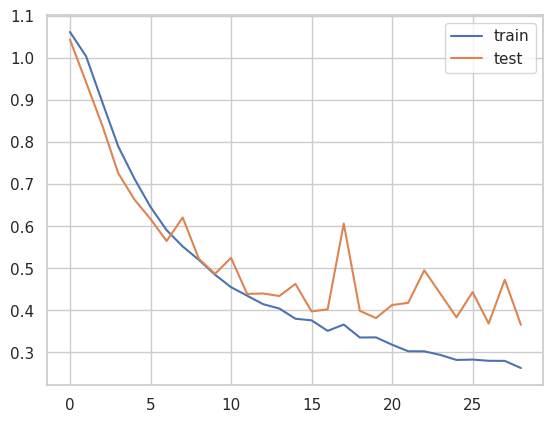

In [43]:
# Visualize train and test loss
plt.plot(WE_3C_GAPL.history['loss'], label='train')
plt.plot(WE_3C_GAPL.history['val_loss'], label='test')
plt.legend()
plt.show()

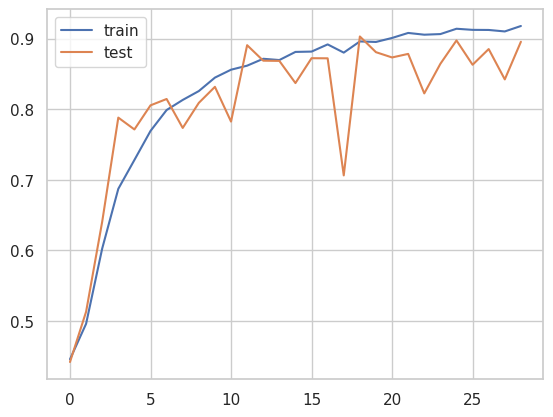

In [44]:
# Visualize train and test accuracy
plt.plot(WE_3C_GAPL.history['accuracy'], label='train')
plt.plot(WE_3C_GAPL.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Save Word Embedding Based Model for 3-Class Text Classification with Global Average Pooling Layer to WE_3C_GAPL.keras

### **5.4. Word Embedding with Global Average Pooling Layer and Dense Layer**

In [45]:
# Callbacks
# ModelCheckpoint Callback
checkpoint_filepath = os.path.join('saved_models', 'WE_3C_GAPLBN.keras')
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,      # Path to save the best model
    monitor='val_accuracy',            # Metric to monitor (validation accuracy)
    save_best_only=True,               # Only save the model with the best value
    mode='max',                        # Monitor for the maximum value (for accuracy)
    save_weights_only=False,           # Save the entire model (not just weights)
    verbose=1                          # Print messages when a new best is found
)

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Metric to monitor (validation accuracy)
    patience=10,                       # Number of epochs with no improvement to tolerate
    restore_best_weights=True,         # Restore model weights from the epoch with the best value
    verbose=1                          # Print messages when early stopping is triggered
)

In [46]:
# Model Building
model = Sequential([
    # Embedding Layer: More expressive with higher embedding dimensions
    Embedding(max_features, embedding_dim, input_length=X2_padded.shape[1]),

    # Spatial Dropout: Often better than regular Dropout for text
    SpatialDropout1D(0.2),

    # GlobalAveragePooling1D: Remains effective
    GlobalAveragePooling1D(),

    # Additional Dense Layer for Flexibility
    Dense(128, activation='relu'),

    # Dropout Layer: Randomly sets a fraction (0.2) of input units to 0 to prevent overfitting
    Dropout(0.2),

    # Dense (Output) Layer
    Dense(3, activation='softmax')
])

# Compile the Model
model.compile(
    loss='sparse_categorical_crossentropy',     # Loss for multi-class classification
    optimizer='adam',                           # Optimizer
    metrics=['accuracy']                        # Track accuracy during training
)

# Train the Model (with Callbacks)
WE_3C_GAPLBN = model.fit(
    X2_train, y2_train,
    epochs=100,                                 # Maximum number of epochs to train
    validation_data=(X2_test, y2_test),             # Data to evaluate after each epoch
    callbacks=[checkpoint, early_stopping]      # Callbacks to monitor progress and save best models
)

Epoch 1/100
820/821 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4329 - loss: 1.0730
Epoch 1: val_accuracy improved from -inf to 0.51189, saving model to saved_models/WE_3C_GAPLBN.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.4330 - loss: 1.0730 - val_accuracy: 0.5119 - val_loss: 1.0054
Epoch 2/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5325 - loss: 0.9570
Epoch 2: val_accuracy improved from 0.51189 to 0.61963, saving model to saved_models/WE_3C_GAPLBN.keras
821/821 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.5326 - loss: 0.9569 - val_accuracy: 0.6196 - val_loss: 0.7300
Epoch 3/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6776 - loss: 0.7391
Epoch 3: val_accuracy did not improve from 0.61963
821/821 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.6777 - loss: 0.7390 - val_accuracy: 0.5354 - val_loss: 0.8917
Epoch 4/100
819/821 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7493 - loss: 0.6154
Epoch 4: val_accuracy improved from

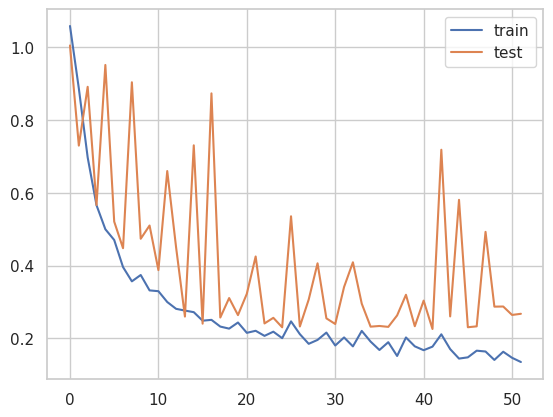

In [47]:
# Visualize train and test loss
plt.plot(WE_3C_GAPLBN.history['loss'], label='train')
plt.plot(WE_3C_GAPLBN.history['val_loss'], label='test')
plt.legend()
plt.show()

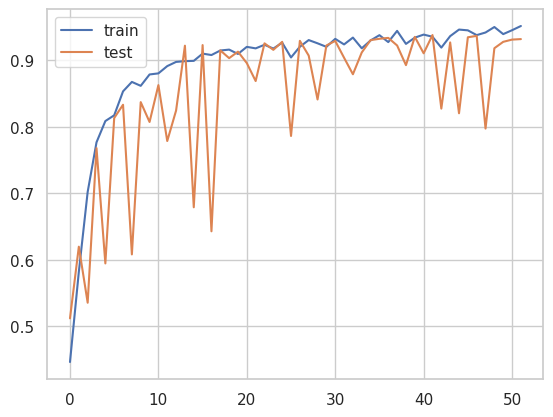

In [48]:
# Visualize train and test accuracy
plt.plot(WE_3C_GAPLBN.history['accuracy'], label='train')
plt.plot(WE_3C_GAPLBN.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Save Word Embedding Based Model for 3-Class Text Classification with Global Average Pooling Layer and Dense Layer to WE_3C_GAPLBN.keras

### **5.5. Models Comparison**

In [49]:
# Show all saved models accuracy
# Load TFIDF_3C_MLP - Training time 2 minutes
TFIDF_3C_MLP = joblib.load('saved_models/TFIDF_3C_MLP.pkl')
y1_pred = TFIDF_3C_MLP.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Accuracy of TFIDF_3C_MLP: {accuracy:.3f}")

# Load TFIDF_3C_DL - Training time 18 minutes
TFIDF_3C_DL = tf.keras.models.load_model('saved_models/TFIDF_3C_DL.keras')
_, accuracy_TFIDF_3C_DL = TFIDF_3C_DL.evaluate(X1_test, y1_test, verbose=0)
print(f"Accuracy of TFIDF_3C_DL: {accuracy_TFIDF_3C_DL:.3f}")

# Load WE_3C_GAPL - Training time 19 minutes
WE_3C_GAPL = tf.keras.models.load_model('saved_models/WE_3C_GAPL.keras')
_, accuracy_WE_3C_GAPL = WE_3C_GAPL.evaluate(X2_test, y2_test, verbose=0)
print(f"Accuracy of WE_3C_GAPL: {accuracy_WE_3C_GAPL:.3f}")

# Load WE_3C_GAPLBN - Training time 26 minutes
WE_3C_GAPLBN = tf.keras.models.load_model('saved_models/WE_3C_GAPLBN.keras')
_, accuracy_WE_3C_GAPLBN = WE_3C_GAPLBN.evaluate(X2_test, y2_test, verbose=0)
print(f"Accuracy of WE_3C_GAPLBN: {accuracy_WE_3C_GAPLBN:.3f}")

Accuracy of TFIDF_3C_MLP: 0.927
Accuracy of TFIDF_3C_DL: 0.926
Accuracy of WE_3C_GAPL: 0.903
Accuracy of WE_3C_GAPLBN: 0.938


## **6. Results**

1. **TF-IDF with Multi-Layer Perceptron** ranked second, achieving an accuracy of 92.7%. This model required only 12 minutes for training, faster than the other models.

2. **TF-IDF with Dense Layer** ranked third, with a test accuracy of 92.6%. This model showed the highest risk of overfitting, evidenced by a 4.5% difference between training (97.1%) and test accuracy. Training took 32 minutes across 25 epochs, with each epoch averaging 77 seconds.  The model demonstrated low variance, as shown by the consistent loss and accuracy plots.

3. **Word Embedding with Global Average Pooling Layer** ranked last, with an accuracy of 90.3%. This model exhibited a lower risk of overfitting than the previous model (TF-IDF with Dense Layer), with a 1.2% difference between training (89.1%) and test accuracy. Training took 16 minutes across 29 epochs, with each epoch averaging 33 seconds. The model showed high variance, indicated by fluctuations in the loss and accuracy plots.

4. **Word Embedding with Global Average Pooling Layer and Dense Layer** achieved the highest accuracy of 93.8%. This model demonstrated the lowest risk of overfitting among all models, with a 0.2% difference between training (93.6%) and test accuracy. Training took 31 minutes across 52 epochs, with each epoch averaging 36 seconds. The model showed high variance, indicated by fluctuations in the loss and accuracy plots.

## **7. Conclusion**

Based on the results, the **Word Embedding with Global Average Pooling Layer and Dense Layer** model is recommended for the following reasons:

* **Highest Accuracy:** It achieves the highest accuracy of 93.8%.
* **Lowest Risk of Overfitting:** It demonstrates the lowest risk of overfitting among all models, with only a 0.2% difference between training and test accuracy.

While the model does exhibit high variance, this could potentially be addressed through techniques like regularization or using more training data.

This project successfully developed a text classification model for categorizing YouTube comments from ruangguru's Clash of Champions episodes. The model demonstrates the potential for automated comment analysis and sentiment identification, which can be a valuable tool for ruangguru to understand and engage with its audience. While the model has achieved promising results, there are areas for improvement and considerations for future applications.

## **8. Recommendations**

1. **Address Class Imbalance:** The imbalanced lexicon used for sentiment analysis may lead to biased results, with a tendency to overestimate negative sentiment. Efforts should be made to balance the lexicon or explore alternative sentiment analysis techniques.

2. **Enhance Preprocessing:** The effectiveness of text preprocessing can be further enhanced. Consider incorporating advanced techniques like spell checking, slang handling, and negation handling to improve the accuracy of feature extraction and model performance.

3. **Explore Deep Learning Models:** The project currently utilizes machine learning models. Exploring deep learning architectures, such as recurrent neural networks (RNNs) or transformers, could potentially enhance the model's ability to capture contextual nuances in comments.

4. **Expand Labeling Categories:** Consider expanding the labeling categories beyond sentiment. Incorporating categories like topic, relevance, or engagement level can provide Ruangguru with more comprehensive insights into their audience's feedback and preferences.

5. **Continuous Model Improvement:** As new data becomes available, the model should be continuously retrained and updated to maintain its accuracy and adapt to evolving language patterns and trends in the comments.

By implementing these recommendations, ruangguru can further refine its comment analysis capabilities, gain deeper insights into audience sentiment and engagement, and leverage this information to enhance its content and community interaction strategies.

## **9. Inference**

**[Model](https://github.com/kevinadityaikhsan/ruangguru-sentiment-analysis-classification/tree/main/model)**

In [50]:
# Load necessary libraries and models
WE_3C_GAPLBN = tf.keras.models.load_model('saved_models/WE_3C_GAPLBN.keras')
tokenizer = joblib.load('saved_models/tokenizer.pkl')

# New comments for inference
new_comments = [
    "18:14 dari tantangan cyptarithm aja gw dah tau bahwa pendidikan di indo sama di luar itu beda jauh,apalagi tentang kurikulum nya,tauu kann??pas si sandy sama si axel bilang bahwa dia itu materi yg pernah di pelajari di sekolah dasar,gw aja yg kls 8 baru tau bahwa ada pelajaran kem gitu..jadi inget kata Bertrand Russell \"manusia terlahir tidak tahu,bukan bodoh;mereka dibodohi oleh pendidikan\".",  # Negative
    "Hanif : \"ya karna mereka ahlinya\"",  # Neutral
    "Xaviera sama Shakira bener bener cewe cerdas yg positive vibes banget dan support team nya banget. Sangat mengapresiasi anggotanya, kereennn"  # Positive
]

# Clean and label the new comments
cleaned_comments = [clean_corpus_docs(comment) for comment in new_comments]
labeled_comments = [sentiment_analysis_lexicon_indonesia(comment) for comment in cleaned_comments]

# Tokenize and pad the cleaned comments
new_comments_seq = tokenizer.texts_to_sequences(cleaned_comments)
new_comments_padded = pad_sequences(new_comments_seq, maxlen=128)

# Predict using the loaded model
predictions = WE_3C_GAPLBN.predict(new_comments_padded)

# Interpret predictions
predicted_labels = np.argmax(predictions, axis=1)
label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Print results
for comment, label, predicted_label in zip(new_comments, labeled_comments, predicted_labels):
    print(f"Comment: {comment}")
    print(f"True Label: {label}")
    print(f"Predicted Label: {label_mapping[predicted_label]}")
    print("----")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Comment: 18:14 dari tantangan cyptarithm aja gw dah tau bahwa pendidikan di indo sama di luar itu beda jauh,apalagi tentang kurikulum nya,tauu kann??pas si sandy sama si axel bilang bahwa dia itu materi yg pernah di pelajari di sekolah dasar,gw aja yg kls 8 baru tau bahwa ada pelajaran kem gitu..jadi inget kata Bertrand Russell "manusia terlahir tidak tahu,bukan bodoh;mereka dibodohi oleh pendidikan".
True Label: (-3, 'negative')
Predicted Label: Negative
----
Comment: Hanif : "ya karna mereka ahlinya"
True Label: (0, 'neutral')
Predicted Label: Neutral
----
Comment: Xaviera sama Shakira bener bener cewe cerdas yg positive vibes banget dan support team nya banget. Sangat mengapresiasi anggotanya, kereennn
True Label: (4, 'positive')
Predicted Label: Positive
----


In [51]:
# !pip freeze > requirements.txt